In [1]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from tensorflow.keras.utils import plot_model

In [2]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
cd /content/drive

/content/drive


In [6]:
cd MyDrive


/content/drive/MyDrive


In [7]:
cd 'data for colab'

/content/drive/MyDrive/data for colab


In [8]:
data=pd.read_csv("hot_topics_data_100K.csv")

In [9]:
data.shape

(100000, 3)

In [10]:
test=pd.read_csv("test_set_2000.csv")

In [11]:
#Remove test from data
data=data[~(data["FINDINGS"].isin(test["FINDINGS"])&data["IMPRESSION"].isin(test["IMPRESSION"]))]

In [ ]:
data.shape

(96503, 3)

In [12]:
#Drop duplicates
data.drop_duplicates(subset=['FINDINGS'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)

In [13]:
#drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['FINDINGS']:
    cleaned_text.append(text_cleaner(t))

In [16]:
cleaned_text_test = []
for t in test['FINDINGS']:
    cleaned_text_test.append(text_cleaner(t))

In [17]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['IMPRESSION']:
    cleaned_summary.append(summary_cleaner(t))
#Call the above function
cleaned_summary_test = []
for t in test['IMPRESSION']:
    cleaned_summary_test.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

test['cleaned_text']=cleaned_text_test
test['cleaned_summary']=cleaned_summary_test
test['cleaned_summary'].replace('', np.nan, inplace=True)
test.dropna(axis=0,inplace=True)

In [18]:
#Add the START and END special tokens at the beginning and end of the summary
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')
#Add the START and END special tokens at the beginning and end of the summary
test['cleaned_summary'] = test['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')

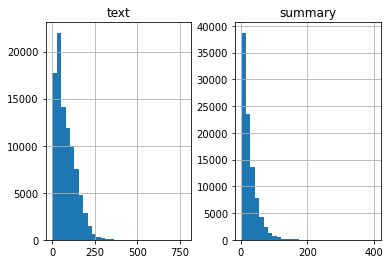

In [ ]:
#analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [19]:
#From above histogram we define
max_len_text=200 
max_len_summary=54

In [20]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 


In [21]:
x_test=test["cleaned_text"]
y_test=test["cleaned_summary"]

In [22]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [23]:
x_test=x_tokenizer.texts_to_sequences(x_test)
x_test   =   pad_sequences(x_test, maxlen=max_len_text, padding='post')

In [24]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [25]:
y_test= y_tokenizer.texts_to_sequences(y_test)
y_test   =   pad_sequences(y_test, maxlen=max_len_summary, padding='post')

In [26]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb)
 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 500)     9730000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 500)    6963000     input_2[0][0]                    
_______________________________________________________________________________________

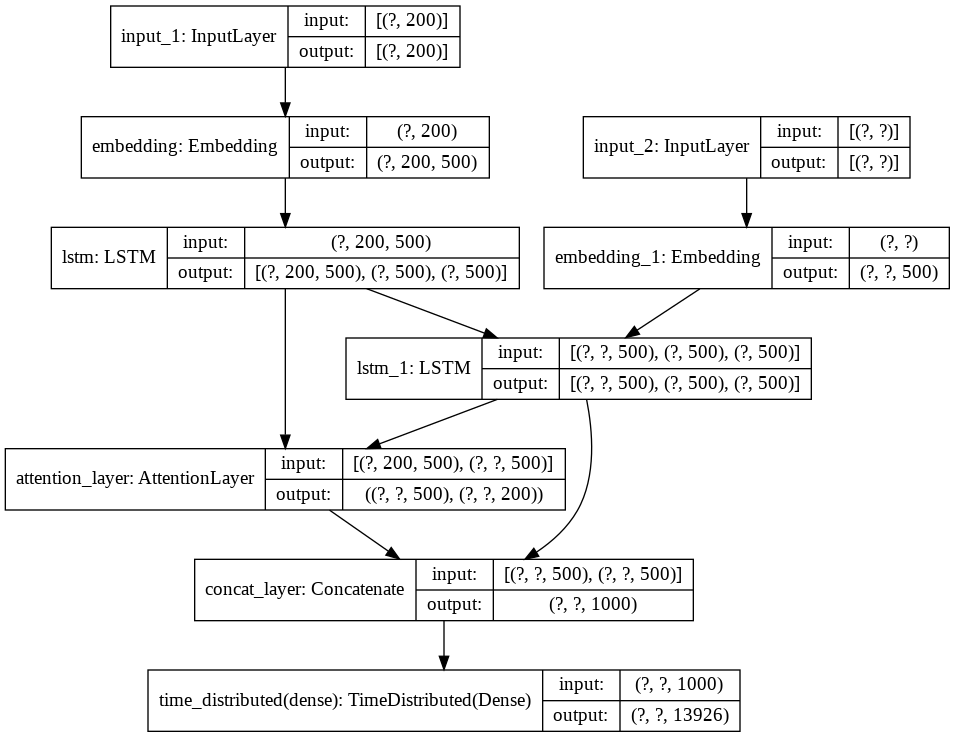

In [ ]:
plot_model(model,show_shapes=True)

In [27]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [29]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], callbacks=[es],epochs=25,batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/25
1288/1288 [==============================] - 527s 409ms/step - loss: 1.8333 - val_loss: 1.4581
Epoch 2/25
1288/1288 [==============================] - 527s 409ms/step - loss: 1.4050 - val_loss: 1.3445
Epoch 3/25
1288/1288 [==============================] - 527s 409ms/step - loss: 1.3079 - val_loss: 1.2910
Epoch 4/25
1288/1288 [==============================] - 526s 409ms/step - loss: 1.2491 - val_loss: 1.2608
Epoch 5/25
1288/1288 [==============================] - 526s 409ms/step - loss: 1.1998 - val_loss: 1.2408
Epoch 6/25
1288/1288 [==============================] - 526s 408ms/step - loss: 1.1545 - val_loss: 1.2195
Epoch 7/25
1288/1288 [==============================] - 527s 409ms/step - loss: 1.1083 - val_loss: 1.2015
Epoch 8/25
1288/1288 [==============================] - 526s 409ms/step - loss: 1.0627 - val_loss: 1.1859
Epoch 9/25
1288/1288 [==============================] - 526s 409ms/step - loss: 1.0195 - val_loss: 1.1751
Epoch 10/25
1288/1288 [=======================

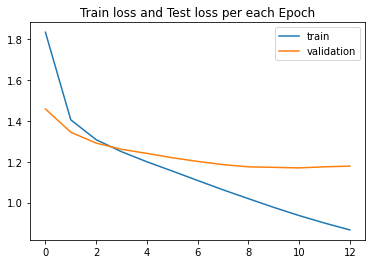

In [30]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.title("Train loss and Test loss per each Epoch")
pyplot.legend()
pyplot.show()

In [31]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [32]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [33]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (54-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [34]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [35]:
y_true=[]
y_pred=[]
for i in range(0,1999):
  y_true.append(seq2summary(y_test[i]))
  y_pred.append(decode_sequence(x_test[i].reshape(1,max_len_text)))


In [36]:
pred_output=pd.DataFrame()
pred_output["y_pred"]=y_pred
pred_output["y_true"]=y_true

In [37]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()

def sentence_bleu_n(ref, hyp, weights):
  return sentence_bleu(references = [ref.split()], 
                       hypothesis = hyp.split(),
                       weights = weights,
                       smoothing_function = chencherry.method1)


In [38]:
pip install Rouge

In [39]:
from rouge import Rouge 

In [40]:
def sentence_rouge(ref, hyp,weight):
  rouge = Rouge()
  scores=rouge.get_scores(ref, hyp)
  if weight==1:
    return scores[0]["rouge-1"]["f"]
  else:
    return scores[0]["rouge-2"]["f"]

In [41]:
# bleu1
pred_output['bleu1'] = pred_output[['y_pred', 'y_true']].apply(lambda x: sentence_bleu_n(x[1], x[0], weights = [1,0,0,0]), axis=1)

# bleu2
pred_output['bleu2'] = pred_output[['y_pred', 'y_true']].apply(lambda x: sentence_bleu_n(x[1], x[0], weights = [0,1,0,0]), axis=1)

#Rouge1
pred_output["rouge1"]=pred_output[['y_pred', 'y_true']].apply(lambda x: sentence_rouge(x[1], x[0], weight = 1), axis=1)

#Rouge2
pred_output["rouge2"]=pred_output[['y_pred', 'y_true']].apply(lambda x: sentence_rouge(x[1], x[0], weight = 2), axis=1)

In [ ]:
pred_output.head()

,y_pred,y_true,bleu1,bleu2,rouge1,rouge2
0,there is no evidence for acute intracranial h...,subacute infarction involving the right poster...,0.091566,0.402890,0.156250,0.000000
1,interval development of large right frontopar...,over the interval previously demonstrated mode...,0.204586,0.026557,0.250000,0.032258
2,no evidence of pulmonary embolism bilateral l...,no evidence of pulmonary embolism centrilobula...,0.229436,0.147494,0.434783,0.272727
3,enteric tube coiled in the distal esophagus w...,no change in appearance of enteric tube as abo...,0.250000,0.066667,0.250000,0.066667
4,no evidence of intracranial hemorrhage or mas...,no evidence of intracranial hemorrhage or mass...,0.344057,0.264538,0.558824,0.424242


In [42]:
pred_output["bleu1"].mean()

0.24891401905522278

In [43]:
pred_output["bleu2"].mean()

0.15855914834863916

In [44]:
pred_output["rouge1"].mean()

0.34405679953315704

In [45]:
pred_output["rouge2"].mean()

0.20027401785379004

In [ ]:
for i in range(0,99):
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_len_text)))
    print("\n")

Review: diffusion restriction present involving right parietal lobe including superior inferior parietal lobules well adjacent right temporal lobe posterior aspect right superior temporal gyrus posterior aspect right insular cortex additional diffusion restriction present along right paracentral lobule posterior aspects right cingulate gyrus areas hyperintense flair mri adjacent cerebral swelling leptomeningeal enhancement mild degree periventricular subcortical punctate hyperintense white matter lesions present identified flair images susceptibility imaging low signal focus present along right orbital gyrus associated surrounding flair signal hyperintensity well associated signal hyperintensity significant contrast enhancement vascular flow voids present distal carotid vertebral arteries basilar artery proximal anterior middle posterior cerebral arteries well internal cerebral veins superior sagittal sinus visualized portions paranasal sinuses clear visualized portions mastoid air cel